In [1]:
%load_ext autoreload
%autoreload 2

# Latent Playground

In [2]:
import io
import base64
import numpy as np
import cv2
from tqdm import tqdm

import ipywidgets as widgets
from IPython.display import HTML, Image, display, clear_output

import vae_model

import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib inline

C:\Users\vecse\Anaconda3\envs\kaggle\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Create model & Load trained weights

In [3]:
LATENT_VECTOR_LEN = 32

In [4]:
vae = vae_model.VAE(LATENT_VECTOR_LEN)

[*] Model is built and compiled


In [5]:
weights_path = "saved_weights/circle_test.h5"

In [6]:
vae.vae.load_weights(weights_path)

## Most important latent space elemennts

### Construct reference decoded image

In [7]:
ref_encoded_image_vector = np.zeros(LATENT_VECTOR_LEN, dtype=np.float32)
ref_decoded_image = vae.decoder.predict(np.expand_dims(ref_encoded_image_vector, 0))[0]

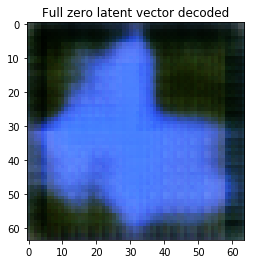

In [8]:
plt.title("Full zero latent vector decoded")
plt.imshow(ref_decoded_image);

### Measure feature importance

In [9]:
value_difference = -0.01

In [10]:
decoded_image_differences = []

for feature_index in tqdm(range(LATENT_VECTOR_LEN)):
    new_latent_vector = ref_encoded_image_vector.copy()
    new_latent_vector[feature_index] += value_difference
    new_decoded_image = vae.decoder.predict(np.expand_dims(new_latent_vector, 0))[0]
    decoded_image_diff = np.sum(np.abs(ref_decoded_image-new_decoded_image))
    decoded_image_differences.append(decoded_image_diff)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 286.51it/s]


In [11]:
most_important_feature_indexes = np.argsort(decoded_image_differences)[::-1]

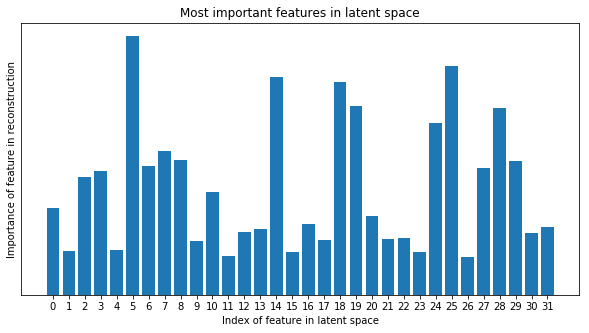

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(len(decoded_image_differences)), decoded_image_differences)
ax.set_title("Most important features in latent space")
ax.set_yticks([])
ax.set_xticks(np.arange(0, len(decoded_image_differences)))
ax.set_xlabel("Index of feature in latent space")
ax.set_ylabel("Importance of feature in reconstruction");

## Interactive Image Reconstruction

In [24]:
display_n_important_features = 3

In [25]:
encoded_image_vec = np.zeros(LATENT_VECTOR_LEN, dtype=np.float32)

### Sliders - Latent space values

In [26]:
sliders_min = -5
sliders_max = 5
slider_widgets = []

# Initialize the sliders
for i, x in enumerate(encoded_image_vec):
    slider = widgets.FloatSlider(description=str(i),
                                 min=sliders_min,
                                 max=sliders_max,
                                 step=0.001,
                                 continuous_update=False,
                                 value=x)
    
    if i in most_important_feature_indexes[:display_n_important_features]:
        slider.style.handle_color = "#ff0000"
    
    slider_widgets.append(slider)
    
# Function which gets the slider values and updates the plot
def vae_widgets_decoder(change):
    encoded_image_vec = [s.value for s in slider_widgets]
    decoded_image = vae.decoder.predict(np.expand_dims(encoded_image_vec, 0))[0]
    with out:
        clear_output(wait=True)
        fig = plt.figure()
        plt.grid()
        plt.title("Decoded image")
        plt.imshow(decoded_image)
        plt.show()
        
# Set callbacks when the value changes of a slider
for s in slider_widgets:
    s.observe(vae_widgets_decoder, "value")

### Randomize button

In [27]:
randomize_button = widgets.Button(description="Randomize")

# Callback function when the button gets clicked
def on_randomize_button_click(b):
    random_values = np.random.uniform(sliders_min, sliders_max, 32)
    for s, v in zip(slider_widgets, random_values):
        s.value = v
        
# Set callback for button click
randomize_button.on_click(on_randomize_button_click)

### Output view

In [28]:
out = widgets.Output()

# Create an extra column for the output and the randomize button
output_column = widgets.VBox((out, randomize_button))

### Construct the UI

In [29]:
slider_columns_num = 3

# Organize the sliders into columns
slider_columns = []
for x in np.array_split(slider_widgets, slider_columns_num):
    col = widgets.VBox(tuple(x))
    slider_columns.append(col)

# Add the output view as an extra column
slider_columns.append(output_column)

# Organize the columns into a horizontal box
hbox = widgets.HBox(slider_columns)
# This func needs to be called, so the output view is displayed initially
vae_widgets_decoder(None)

### Showtime

In [30]:
display(hbox)